#**Satellite Rainfall Data Calibration using Ensemble (Random Forest) Model Regression, Study Case: BMKG Bandung Ground Station** <br>
**Abstract:** <br>



<br>

_**keywords**: rainfall, calibration, ground station, satellite data_

## Purpose

In [611]:
# Import Module Set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## **Data Preparation**

### **Import Data** <br>
Description of data from BMKG

* Tn: Minimum temperature (°C)
* Tx: Maximum temperature (°C)
* Tavg: Average temperature (°C)
* RH_avg : Average humidity (%)
* RR : Rainfall (mm)
* ss : Length of sunshine
* ff_x : Maximum wind speed (m/s)
* ddd_x : Wind direction at maximum speed (°)
* ff_avg : Average wind speed (m/s)
* ddd_car : Most wind direction (°)

In [612]:
# Import Data BMKG
raw_bmkg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/BMKG Klimatologi Bandung 2022-2024.csv')
print(raw_bmkg.info())
# Import Data GSMaP Satellite
raw_gsmap = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/GSMaP 2022-2024 Rainfall Data.csv')
print(raw_gsmap.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     1096 non-null   object 
 1   TN       1090 non-null   object 
 2   TX       1090 non-null   object 
 3   TAVG     1090 non-null   object 
 4   RH_AVG   1090 non-null   object 
 5   RR       1090 non-null   object 
 6   SS       1090 non-null   object 
 7   FF_X     1090 non-null   float64
 8   DDD_X    1090 non-null   float64
 9   FF_AVG   1090 non-null   float64
 10  DDD_CAR  1090 non-null   object 
dtypes: float64(3), object(8)
memory usage: 94.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1096 non-null   object 
 1   dailyPrecipRate  1096 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.3+ K

In [613]:
# Change the date format to 'yyyy-mm-dd'
raw_bmkg['DATE'] = pd.to_datetime(raw_bmkg['DATE'])
raw_gsmap['date'] = pd.to_datetime(raw_gsmap['date'])

### **Data Cleaning**

#### A. Clearing & Imputation of BMKG Data

In [614]:
clean_bmkg = raw_bmkg.copy()

# Only rainfall data, drop other column
clean_bmkg = clean_bmkg.drop(columns=['TN', 'TX', 'TAVG', 'RH_AVG','SS', 'FF_X', 'DDD_X', 'FF_AVG', 'DDD_CAR'])

# Replace non-numeric values with NaN
clean_bmkg['RR'] = pd.to_numeric(clean_bmkg['RR'], errors='coerce')

print(clean_bmkg.info())
clean_bmkg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1096 non-null   datetime64[ns]
 1   RR      977 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.3 KB
None


,DATE,RR
0,2022-01-01,0.0
1,2022-01-02,NaN
2,2022-01-03,0.0
3,2022-01-04,NaN
4,2022-01-05,0.0
...,...,...
1091,2024-12-27,0.0
1092,2024-12-28,1.5
1093,2024-12-29,0.1
1094,2024-12-30,0.0


In [615]:
# Replace '8888', '9999', and '-' with NaN
clean_bmkg['RR'] = clean_bmkg['RR'].replace([8888, 9999,"-"], np.nan)

# Apply a moving average (MA) 7 to fill NaN values
clean_bmkg['RR'] = clean_bmkg['RR'].fillna(clean_bmkg['RR'].rolling(window=7, min_periods=1).mean())

print(clean_bmkg.info())
clean_bmkg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1096 non-null   datetime64[ns]
 1   RR      1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.3 KB
None


,DATE,RR
0,2022-01-01,0.00
1,2022-01-02,0.00
2,2022-01-03,0.00
3,2022-01-04,0.00
4,2022-01-05,0.00
...,...,...
1091,2024-12-27,0.00
1092,2024-12-28,1.50
1093,2024-12-29,0.10
1094,2024-12-30,0.00


#### B. Cleaning GSMaP Data

In [616]:
clean_gsmap = raw_gsmap.copy()

clean_gsmap.info()
# Data is already cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1096 non-null   datetime64[ns]
 1   dailyPrecipRate  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.3 KB


### **Data Preprocessing**

#### A. Exploratory Data Analysis (EDA) & Adjustment <br>

I wanted to add other variables to add depth/dimension to the overall dataset. In this case I added Lag_Rain (3-Day), Day_of_Year, and GSMaP 3-day Moving Average, GSMaP 7-day Moving Average, and GSMaP 30-day Moving Average.

In [617]:
# Combine all raw (cleaned) dataset
df = pd.merge(clean_bmkg,clean_gsmap, left_on = 'DATE', right_on = 'date', how = 'inner')
df = df.drop(columns=['date'])
df = df.rename(columns={'dailyPrecipRate':'GSMaP'})
df

,DATE,RR,GSMaP
0,2022-01-01,0.00,1.445
1,2022-01-02,0.00,1.922
2,2022-01-03,0.00,0.001
3,2022-01-04,0.00,0.004
4,2022-01-05,0.00,7.782
...,...,...,...
1091,2024-12-27,0.00,5.527
1092,2024-12-28,1.50,5.572
1093,2024-12-29,0.10,3.338
1094,2024-12-30,0.00,0.086


In [618]:
# Adding Other Variables from GSMaP Based Data
def add_features (df):

  # Temporal Variable
  df['Day_of_Year'] = df['DATE'].dt.dayofyear
  df['month'] = df['DATE'].dt.month

  # Moving Average
  df['GSMaP_MA_3day'] = df['GSMaP'].rolling(window=3, min_periods=3).mean().fillna(df['RR'])
  df['GSMaP_MA_7day'] = df['GSMaP'].rolling(window=7, min_periods=7).mean().fillna(df['RR'])
  df['GSMaP_MA_30day'] = df['GSMaP'].rolling(window=30, min_periods=30).mean().fillna(df['RR'])

  # Threshold
  max_normal = 10 # correction factor
  min_threshold = 3 # mm

  # Case 1: Normal - both detect significant amounts of rain
  normal_mask = (df['GSMaP'] >= min_threshold) & (df['RR'] >= min_threshold)
  # Case 2: GSMaP missed rain - GSMaP not/very small, but RR detected
  missed_rain_mask = (df['GSMaP'] < min_threshold) & (df['RR'] >= min_threshold)
  # Case 3: GSMaP false alarm - GSMaP detects rain, but very little/no RR
  false_alarm_mask = (df['GSMaP'] >= min_threshold) & (df['RR'] < min_threshold)
  # Case 4: Both do not detect rain
  no_rain_mask = (df['GSMaP'] < min_threshold) & (df['RR'] < min_threshold)

  # Calculate the correction factor for each case
  # Case 1
  df.loc[normal_mask, 'Correction_Factor'] = df.loc[normal_mask, 'RR'] / df.loc[normal_mask, 'GSMaP']
  # Case 2
  df.loc[missed_rain_mask, 'Correction_Factor'] = max_normal
  # Case 3
  df.loc[false_alarm_mask, 'Correction_Factor'] = df.loc[false_alarm_mask, 'RR'] / df.loc[false_alarm_mask, 'GSMaP']
  # Case 4
  df.loc[no_rain_mask, 'Correction_Factor'] = 1

  # Limit outlier values
  # Clip normal values to avoid extreme outliers
  df.loc[normal_mask, 'Correction_Factor'] = np.clip(df.loc[normal_mask, 'Correction_Factor'], 0, max_normal)
  # Clip the false alarm value to avoid outliers close to zero
  df.loc[false_alarm_mask, 'Correction_Factor'] = np.clip(df.loc[false_alarm_mask, 'Correction_Factor'], 0.1, 1.0)

  # Add correction type label as an additional feature
  df['Correction_Type'] = 0  # default: normal
  df.loc[missed_rain_mask, 'Correction_Type'] = 1  # missed rain
  df.loc[false_alarm_mask, 'Correction_Type'] = 2  # false alarm
  df.loc[no_rain_mask, 'Correction_Type'] = 3  # no rain

  df = df.round(2)
  return df

add_features(df)

,DATE,RR,GSMaP,Day_of_Year,month,GSMaP_MA_3day,GSMaP_MA_7day,GSMaP_MA_30day,Correction_Factor,Correction_Type
0,2022-01-01,0.00,1.44,1,1,0.00,0.00,0.00,1.00,3
1,2022-01-02,0.00,1.92,2,1,0.00,0.00,0.00,1.00,3
2,2022-01-03,0.00,0.00,3,1,1.12,0.00,0.00,1.00,3
3,2022-01-04,0.00,0.00,4,1,0.64,0.00,0.00,1.00,3
4,2022-01-05,0.00,7.78,5,1,2.60,0.00,0.00,0.10,2
...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,0.00,5.53,362,12,8.09,5.58,6.97,0.10,2
1092,2024-12-28,1.50,5.57,363,12,3.83,6.25,6.66,0.27,2
1093,2024-12-29,0.10,3.34,364,12,4.81,6.07,6.62,0.10,2
1094,2024-12-30,0.00,0.09,365,12,3.00,5.11,6.43,1.00,3


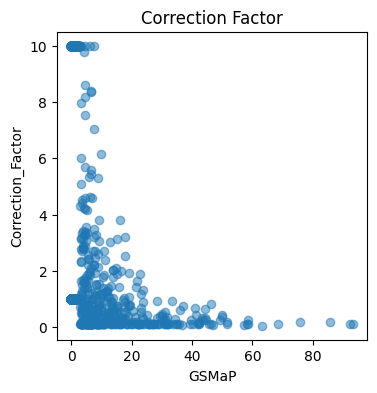

In [619]:
plt.figure(figsize=(4,4))
plt.scatter(df['GSMaP'], df['Correction_Factor'], alpha=0.5,)
plt.title('Correction Factor')
plt.xlabel('GSMaP')
plt.ylabel('Correction_Factor')
plt.show()

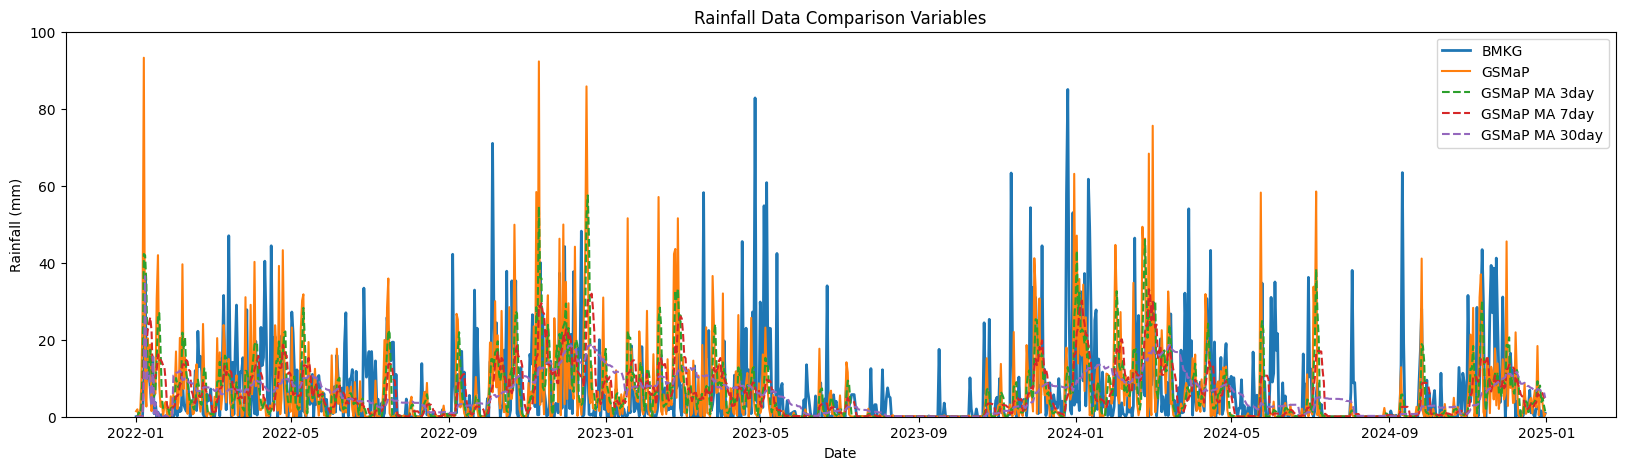

In [620]:
plt.figure(figsize=(20,5))
plt.plot(df['DATE'], df['RR'], label='BMKG',linewidth=2)
plt.plot(df['DATE'], df['GSMaP'], label='GSMaP')


plt.plot(df['DATE'], df['GSMaP_MA_3day'], label='GSMaP MA 3day', linestyle='--')
plt.plot(df['DATE'], df['GSMaP_MA_7day'], label='GSMaP MA 7day', linestyle='--')
plt.plot(df['DATE'], df['GSMaP_MA_30day'], label='GSMaP MA 30day', linestyle='--')

plt.title('Rainfall Data Comparison Variables')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,100)
plt.legend()
plt.show()

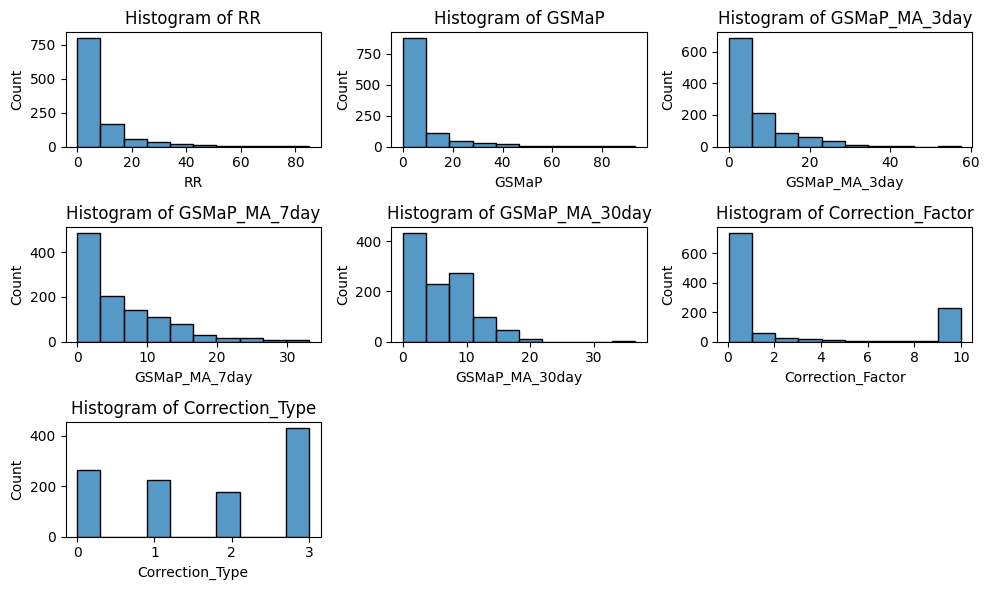

In [621]:
df_no_date = df.drop(columns=['DATE','Day_of_Year','month'])
num_features = len(df_no_date.columns)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 2 * num_rows))

for i, column in enumerate(df_no_date.columns):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(df[column], bins=10, ax=axes[row, col])
    axes[row, col].set_title(f"Histogram of {column}")

# Turn off any unused subplots
for i in range(num_features, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

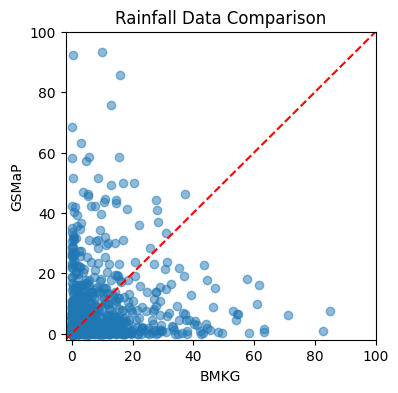

In [622]:
plt.figure(figsize=(4,4))
plt.scatter(df['RR'], df['GSMaP'], alpha=0.5,)
plt.plot([-2, 100], [-2, 100], color='red', linestyle='--')
plt.title('Rainfall Data Comparison')
plt.xlabel('BMKG')
plt.ylabel('GSMaP')
plt.xlim(-2,100)
plt.ylim(-2,100)
plt.show()

In [623]:
df.describe()

,DATE,RR,GSMaP,Day_of_Year,month,GSMaP_MA_3day,GSMaP_MA_7day,GSMaP_MA_30day,Correction_Factor,Correction_Type
count,1096,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,2023-07-02 12:00:00,6.753155,6.166947,183.166971,6.521898,6.165015,6.153137,6.040771,2.908555,1.708029
min,2022-01-01 00:00:00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.047553,0.000000
25%,2022-10-01 18:00:00,0.000000,0.061000,92.000000,4.000000,0.219417,0.650071,2.038158,0.714500,1.000000
50%,2023-07-02 12:00:00,1.900000,1.377000,183.000000,7.000000,3.094333,4.207500,6.091233,1.000000,2.000000
75%,2024-04-01 06:00:00,9.031250,6.956500,274.250000,10.000000,9.043000,9.632714,8.883100,3.034962,3.000000
max,2024-12-31 00:00:00,85.000000,93.242000,366.000000,12.000000,57.479333,33.120857,36.500000,10.000000,3.000000
std,NaN,11.144922,11.222967,105.510927,3.450561,8.165787,6.513058,4.734584,3.785005,1.214287


#### B. Scaling Data using Standar Scaler

In [624]:
df_scale = df.copy()

x = df_scale.drop(columns=['RR','DATE','Correction_Factor'])
y = df_scale['Correction_Factor'].drop(columns=['DATE'])
date = df_scale['DATE']

gsmap = df_scale['GSMaP']

scaler = StandardScaler()
columns_to_scale = ['GSMaP','Day_of_Year','month','GSMaP_MA_3day','GSMaP_MA_7day','GSMaP_MA_30day','Correction_Factor','Correction_Type']

x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
y_scaled = pd.DataFrame(y_scaled, columns=['Correction_Factor'])

#### C. Train Test Splitting

In [625]:
# Combination of 80% Training and 20% Testing
x_train,x_test, y_train,y_test,date_train,date_test = train_test_split(x_scaled,y_scaled,date,test_size=0.2,random_state=42,shuffle=True)

## **Model Regression: Random Forest**

In [626]:
# XGBoost Regression

model_rf = GradientBoostingRegressor(n_estimators=200,random_state=42)
model_rf.fit(x_train, y_train)

y_pred_rf = model_rf.predict(x_test)

# Inverse transform the scaled prediction to get the original scale
y_pred_rf_original_scale = scaler.inverse_transform(np.concatenate([y_pred_rf.reshape(-1,1), x_test], axis=1))[:, 0]

#Similarly, inverse transform y_test
y_test_original_scale = scaler.inverse_transform(y_test)

#Now you can use y_pred_rf_original_scale and y_test_original_scale for evaluation metrics
rmse_rf = np.round(root_mean_squared_error(y_test_original_scale, y_pred_rf_original_scale),3)
mae_rf = np.round(mean_absolute_error(y_test_original_scale,y_pred_rf_original_scale),3)
r2_rf = np.round(r2_score(y_test_original_scale,y_pred_rf_original_scale),3)
correlation = np.round(np.corrcoef(y_test_original_scale.ravel(),y_pred_rf_original_scale)[0, 1],3)


print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")
print(f"R-squared: {r2_rf}")
print(f"Correlation: {correlation}")

RMSE: 1.293
MAE: 0.471
R-squared: 0.899
Correlation: 0.949


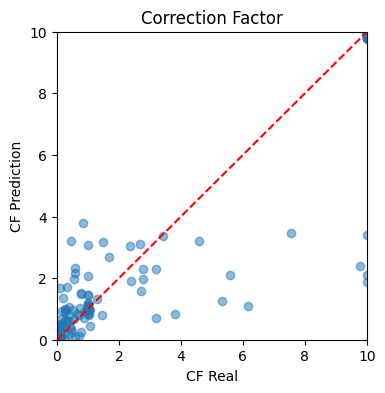

In [627]:
plt.figure(figsize=(4,4))
plt.scatter(y_test_original_scale, y_pred_rf_original_scale, alpha=0.5)
plt.plot([0, 15], [0, 15], color='red', linestyle='--')
plt.title('Correction Factor')
plt.xlabel('CF Real')
plt.ylabel('CF Prediction')
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

In [628]:
feature_importances = model_rf.feature_importances_
print("Feature Importances RF:")
for i, feature_name in enumerate(x.columns):
    print(f"{feature_name}: {np.round(feature_importances[i]*100.0,2)} %")

Feature Importances RF:
GSMaP: 56.13 %
Day_of_Year: 0.53 %
month: 0.01 %
GSMaP_MA_3day: 0.68 %
GSMaP_MA_7day: 0.41 %
GSMaP_MA_30day: 0.66 %
Correction_Type: 41.57 %


In [629]:
# Multiply y_pred_rf_original_scale with GSMaP values from the test set
rainfall_pred = np.abs(y_pred_rf_original_scale * df.loc[date_test.index, 'GSMaP'].values)

rainfall_test = df.loc[date_test.index, 'GSMaP'].values

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Date': date_test.values,  # Assuming date_test is a Series or array-like
    'GSMaP': rainfall_test,
    'BMKG': df.loc[date_test.index, 'RR'].values,
    'Predicted_Rainfall': rainfall_pred
}).sort_values(by='Date').reset_index(drop=True)


# Example usage for evaluation:
rmse_multiplied = np.round(root_mean_squared_error(rainfall_test, rainfall_pred), 3)
mae_multiplied = np.round(mean_absolute_error(rainfall_test, rainfall_pred), 3)
r2_multiplied = np.round(r2_score(rainfall_test, rainfall_pred), 3)

print(f"Test Dataset RMSE: {rmse_multiplied}")
print(f"Test Dataset MAE: {mae_multiplied}")
print(f"Test Dataset R-squared: {r2_multiplied}")

results_df.round(2)

Test Dataset RMSE: 9.776
Test Dataset MAE: 5.614
Test Dataset R-squared: 0.107


,Date,GSMaP,BMKG,Predicted_Rainfall
0,2022-01-04,0.00,0.00,0.00
1,2022-01-11,13.15,11.58,9.09
2,2022-01-13,1.44,2.80,1.19
3,2022-01-24,3.89,0.30,0.45
4,2022-01-31,6.90,0.70,1.27
...,...,...,...,...
215,2024-12-14,2.66,0.30,2.27
216,2024-12-23,6.83,0.00,0.50
217,2024-12-26,0.39,2.80,0.46
218,2024-12-28,5.57,1.50,0.20


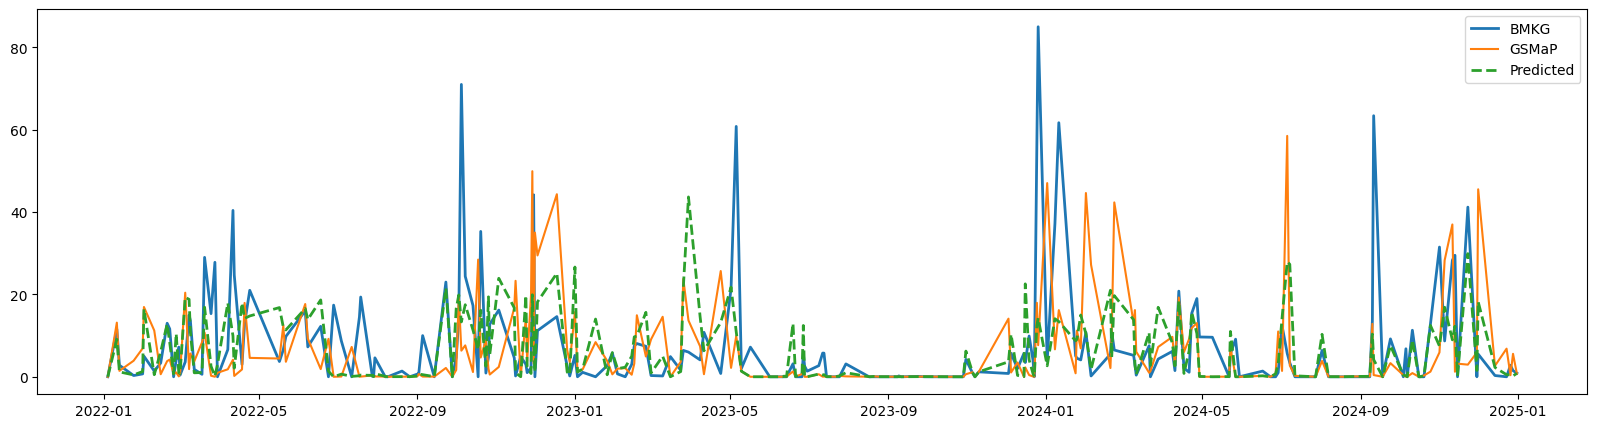

In [630]:
plt.figure(figsize=(20,5))
plt.plot(results_df['Date'], results_df['BMKG'], label='BMKG',linewidth=2)
plt.plot(results_df['Date'], results_df['GSMaP'], label='GSMaP')
plt.plot(results_df['Date'], results_df['Predicted_Rainfall'], label='Predicted',linewidth=2,linestyle='--')
plt.legend()
plt.show()

## **Hyperparameter Tuning using GridSearchCV**

### GridSearchCV

In [631]:
# Definition grid parameter for hyperparameter tuning
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':["sqrt", "log2"],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

In [632]:
'''grid_search = GridSearchCV(model_rf, param_grid,cv=5,scoring='neg_max_error')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_'''

"grid_search = GridSearchCV(model_rf, param_grid,cv=5,scoring='neg_max_error')\ngrid_search.fit(x_train, y_train)\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_"

In [633]:
random_search = RandomizedSearchCV(model_rf, param_grid,cv=10,scoring='neg_root_mean_squared_error')
random_search.fit(x_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [634]:
print(best_params)
print(best_model)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.05}
GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='log2',
                          min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, random_state=42)


### Applying the Best Parameters to Random Forest Model<br>
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(n_estimators=200, random_state=42)

In [635]:
model_rf_best = GradientBoostingRegressor(**best_params, random_state=42) # Use **best_params to unpack the dictionary
model_rf_best.fit(x_train, y_train)

y_pred_rf_best = model_rf_best.predict(x_test)

# Inverse transform the scaled prediction
y_pred_rf_best_original_scale = scaler.inverse_transform(np.concatenate([y_pred_rf_best.reshape(-1,1), x_test], axis=1))[:, 0]

rmse_rf_best = np.round(root_mean_squared_error(y_test_original_scale, y_pred_rf_best_original_scale),3)
mae_rf_best = np.round(mean_absolute_error(y_test_original_scale,y_pred_rf_best_original_scale),3)
r2_rf_best = np.round(r2_score(y_test_original_scale,y_pred_rf_best_original_scale),3)
correlation = np.round(np.corrcoef(y_test_original_scale.ravel(),y_pred_rf_best_original_scale)[0, 1],3)

print(f"Best Model - RMSE: {rmse_rf_best}")
print(f"Best Model - MAE: {mae_rf_best}")
print(f"Best Model - R-squared: {r2_rf_best}")
print(f"Correlation: {correlation}")

Best Model - RMSE: 1.247
Best Model - MAE: 0.525
Best Model - R-squared: 0.906
Correlation: 0.953


In [636]:
# Multiply y_pred_rf_original_scale with GSMaP values from the test set
rainfall_pred = y_pred_rf_best_original_scale * df.loc[date_test.index, 'GSMaP'].values

rainfall_test = df.loc[date_test.index, 'GSMaP'].values

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Date': date_test.values,  # Assuming date_test is a Series or array-like
    'GSMaP': rainfall_test,
    'BMKG': df.loc[date_test.index, 'RR'].values,
    'Predicted_Rainfall': rainfall_pred
}).sort_values(by='Date').reset_index(drop=True)


# Example usage for evaluation:
rmse_multiplied = np.round(root_mean_squared_error(rainfall_test, rainfall_pred), 3)
mae_multiplied = np.round(mean_absolute_error(rainfall_test, rainfall_pred), 3)
r2_multiplied = np.round(r2_score(rainfall_test, rainfall_pred), 3)

print(f"Test Dataset RMSE: {rmse_multiplied}")
print(f"Test Dataset MAE: {mae_multiplied}")
print(f"Test Dataset R-squared: {r2_multiplied}")

results_df.round(2)

Test Dataset RMSE: 9.46
Test Dataset MAE: 5.621
Test Dataset R-squared: 0.164


,Date,GSMaP,BMKG,Predicted_Rainfall
0,2022-01-04,0.00,0.00,0.00
1,2022-01-11,13.15,11.58,9.05
2,2022-01-13,1.44,2.80,3.20
3,2022-01-24,3.89,0.30,0.69
4,2022-01-31,6.90,0.70,0.91
...,...,...,...,...
215,2024-12-14,2.66,0.30,2.63
216,2024-12-23,6.83,0.00,1.23
217,2024-12-26,0.39,2.80,0.68
218,2024-12-28,5.57,1.50,-0.22


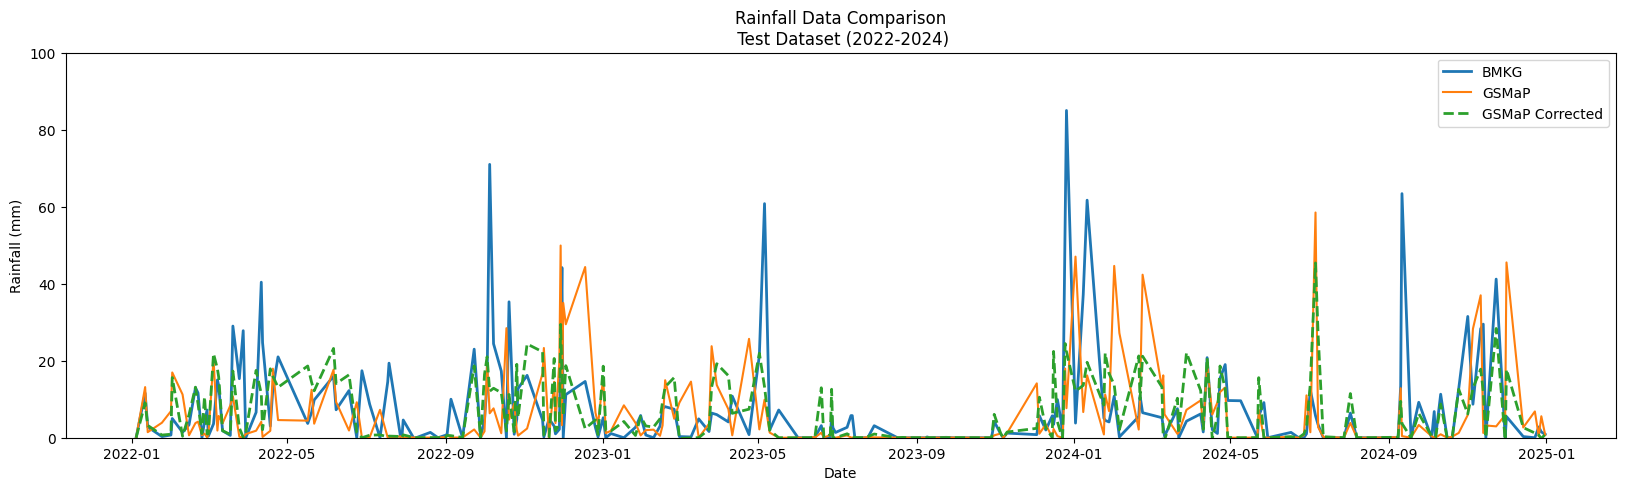

In [637]:
plt.figure(figsize=(20,5))
plt.plot(results_df['Date'], results_df['BMKG'], label='BMKG',linewidth=2)
plt.plot(results_df['Date'], results_df['GSMaP'], label='GSMaP')
plt.plot(results_df['Date'], results_df['Predicted_Rainfall'], label='GSMaP Corrected',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Test Dataset (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,100)
plt.legend()
plt.show()

### Try to Use Model to Overall Dataset (2022-2024)

In [638]:
df_all = df.copy()

x_all = df_all.drop(columns=['RR','DATE','Correction_Factor'])
y_all = df_all['Correction_Factor'].drop(columns=['DATE'])

x_scaled_all = scaler.fit_transform(x_all)
x_scaled_all = pd.DataFrame(x_scaled_all, columns=x_all.columns)

y_scaled_all = scaler.fit_transform(y_all.values.reshape(-1, 1))
y_scaled_all = pd.DataFrame(y_scaled_all, columns=['Correction_Factor'])

In [639]:
# Random Forest Regression

y_pred_rf_all = model_rf.predict(x_scaled_all)

y_pred_rf_all_original_scale = scaler.inverse_transform(np.concatenate([y_pred_rf_all.reshape(-1,1), x_scaled_all], axis=1))[:, 0]
df_all['Correction Factor Model'] = y_pred_rf_all_original_scale.round(2)
df_all['Corrected Rainfall'] = df_all['GSMaP'] * df_all['Correction Factor Model'].round(2)
df_all['Corrected Rainfall'] = df_all['Corrected Rainfall'].clip(lower=0)

df_all = df_all.round(2)
df_all

,DATE,RR,GSMaP,Day_of_Year,month,GSMaP_MA_3day,GSMaP_MA_7day,GSMaP_MA_30day,Correction_Factor,Correction_Type,Correction Factor Model,Corrected Rainfall
0,2022-01-01,0.00,1.44,1,1,0.00,0.00,0.00,1.00,3,1.00,1.44
1,2022-01-02,0.00,1.92,2,1,0.00,0.00,0.00,1.00,3,0.99,1.90
2,2022-01-03,0.00,0.00,3,1,1.12,0.00,0.00,1.00,3,0.99,0.00
3,2022-01-04,0.00,0.00,4,1,0.64,0.00,0.00,1.00,3,0.96,0.00
4,2022-01-05,0.00,7.78,5,1,2.60,0.00,0.00,0.10,2,0.29,2.26
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,0.00,5.53,362,12,8.09,5.58,6.97,0.10,2,0.22,1.22
1092,2024-12-28,1.50,5.57,363,12,3.83,6.25,6.66,0.27,2,0.04,0.22
1093,2024-12-29,0.10,3.34,364,12,4.81,6.07,6.62,0.10,2,0.28,0.93
1094,2024-12-30,0.00,0.09,365,12,3.00,5.11,6.43,1.00,3,1.07,0.09


In [640]:
#Before Correction
rmse_rf_all_before = np.round(root_mean_squared_error(df_all['RR'], df_all['GSMaP']),3)
mae_rf_all_before = np.round(mean_absolute_error(df_all['RR'],df_all['GSMaP']),3)
correlation_all_before = np.round(np.corrcoef( df_all['RR'],df_all['GSMaP'])[0, 1],3)

print('All Dataset (2022-2024) Result\n')
print(f"Before Correction")
print(f"RMSE: {rmse_rf_all_before}")
print(f"MAE: {mae_rf_all_before}")
print(f"Correlation: {correlation_all_before}")

# After Correction
rmse_rf_all_after = np.round(root_mean_squared_error(df_all['RR'], df_all['Corrected Rainfall']),3)
mae_rf_all_after = np.round(mean_absolute_error(df_all['RR'],df_all['Corrected Rainfall']),3)
correlation_all_after = np.round(np.corrcoef( df_all['RR'],df_all['Corrected Rainfall'])[0, 1],3)

print(f"\nAfter Correction")
print(f"RMSE: {rmse_rf_all_after}")
print(f"MAE: {mae_rf_all_after}")
print(f"Correlation: {correlation_all_after}")

All Dataset (2022-2024) Result

Before Correction
RMSE: 14.714
MAE: 8.166
Correlation: 0.135

After Correction
RMSE: 8.736
MAE: 4.054
Correlation: 0.635


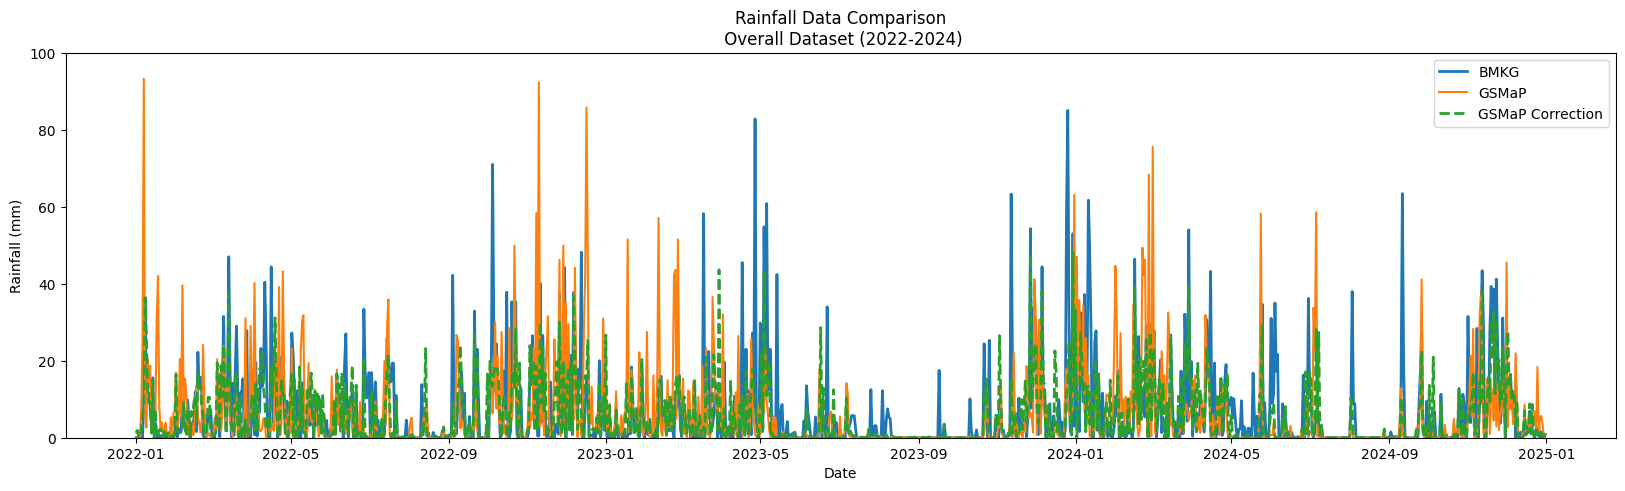

In [641]:
plt.figure(figsize=(20,5))
plt.plot(df_all['DATE'], df_all['RR'], label='BMKG',linewidth=2)
plt.plot(df_all['DATE'], df_all['GSMaP'], label='GSMaP')
plt.plot(df_all['DATE'], df_all['Corrected Rainfall'], label='GSMaP Correction',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Overall Dataset (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,100)
plt.legend()
plt.show()

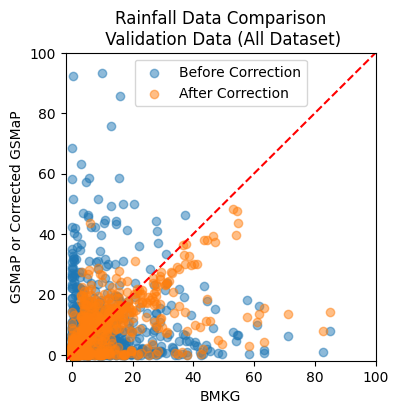

In [642]:
plt.figure(figsize=(4,4))
plt.scatter(df_all['RR'], df_all['GSMaP'], label='Before Correction',alpha=0.5,)
plt.scatter(df_all['RR'], df_all['Corrected Rainfall'], label='After Correction',alpha=0.5,)
plt.plot([-2, 100], [-2, 100], color='red', linestyle='--')
plt.title('Rainfall Data Comparison\n Validation Data (All Dataset)')
plt.xlabel('BMKG')
plt.ylabel('GSMaP or Corrected GSMaP')
plt.xlim(-2,100)
plt.ylim(-2,100)
plt.legend()
plt.show()

## **Validation: Using 2025 Dataset**

### A. Importing 2025 Dataset (only 4 months)

In [643]:
raw_bmkg_2025 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/BMKG Klimatologi Bandung 2025.csv').dropna()
raw_gsmap_2025 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/09 Rainfall Calibration Bandung/GSMaP 2025 Rainfall Data.csv')

# Data Cleaning BMKG 2025 Dataset
raw_bmkg_2025['DATE'] = pd.to_datetime(raw_bmkg_2025['DATE'])
raw_bmkg_2025['RR'] = pd.to_numeric(raw_bmkg_2025['RR'], errors='coerce')

clean_bmkg_2025 = raw_bmkg_2025.copy()
# Replace '8888', '9999', and '-' with NaN
clean_bmkg_2025['RR'] = clean_bmkg_2025['RR'].replace([8888, 9999,"-"], np.nan)

# Apply a moving average (MA) 7 to fill NaN values
clean_bmkg_2025['RR'] = clean_bmkg_2025['RR'].fillna(clean_bmkg_2025['RR'].rolling(window=7, min_periods=1).mean())

print(clean_bmkg_2025.info())

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    120 non-null    datetime64[ns]
 1   RR      119 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB
None


In [644]:
# Data Cleaning GSMaP 2025 Dataset
raw_gsmap_2025['Date'] = pd.to_datetime(raw_gsmap_2025['Date'])
raw_gsmap_2025 = raw_gsmap_2025.rename(columns={'gsmap': 'GSMaP'})
clean_gsmap_2025 = raw_gsmap_2025.copy()

clean_gsmap_2025.info()
# Data is already cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    120 non-null    datetime64[ns]
 1   GSMaP   120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


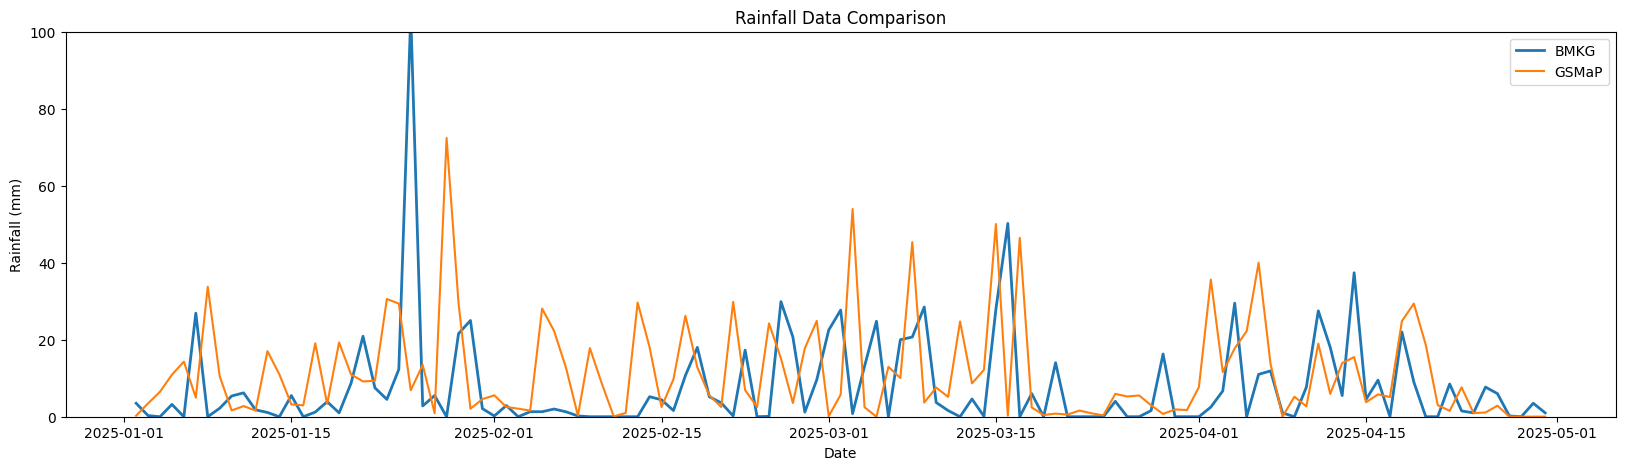

In [645]:
# Combine all raw (cleaned) dataset
df_2025 = pd.merge(clean_bmkg_2025,clean_gsmap_2025, left_on = 'DATE', right_on = 'Date', how = 'inner')
df_2025 = df_2025.drop(columns=['Date']).dropna().round(2)

plt.figure(figsize=(20,5))
plt.plot(df_2025['DATE'], df_2025['RR'], label='BMKG',linewidth=2)
plt.plot(df_2025['DATE'], df_2025['GSMaP'], label='GSMaP')
plt.title('Rainfall Data Comparison')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,100)
plt.legend()
plt.show()

### B. Add Features to 2025 Dataset

In [646]:
add_features(df_2025)

,DATE,RR,GSMaP,Day_of_Year,month,GSMaP_MA_3day,GSMaP_MA_7day,GSMaP_MA_30day,Correction_Factor,Correction_Type
1,2025-01-02,3.5,0.26,2,1,3.50,3.50,3.50,10.00,1
2,2025-01-03,0.3,3.46,3,1,0.30,0.30,0.30,0.10,2
3,2025-01-04,0.0,6.49,4,1,3.40,0.00,0.00,0.10,2
4,2025-01-05,3.2,10.91,5,1,6.95,3.20,3.20,0.29,0
5,2025-01-06,0.0,14.31,6,1,10.57,0.00,0.00,0.10,2
...,...,...,...,...,...,...,...,...,...,...
115,2025-04-26,6.0,2.87,116,4,1.64,5.11,10.76,10.00,1
116,2025-04-27,0.2,0.03,117,4,1.33,2.44,10.66,1.00,3
117,2025-04-28,0.0,0.02,118,4,0.97,2.02,10.64,1.00,3
118,2025-04-29,3.5,0.03,119,4,0.03,1.80,10.58,10.00,1


### C. Model 2025

In [647]:
x_2025 = df_2025.drop(columns=['RR','DATE','Correction_Factor'])
y_2025 = df_2025['Correction_Factor'].drop(columns=['DATE'])

x_scaled_2025 = scaler.fit_transform(x_2025)
x_scaled_2025 = pd.DataFrame(x_scaled_2025, columns=x_2025.columns)

y_scaled_2025 = scaler.fit_transform(y_2025.values.reshape(-1, 1))
y_scaled_2025 = pd.DataFrame(y_scaled_2025, columns=['Correction_Factor'])

In [648]:
# Random Forest Regression

y_pred_rf_2025 = model_rf.predict(x_scaled_2025)

y_pred_rf_2025_original_scale = scaler.inverse_transform(np.concatenate([y_pred_rf_2025.reshape(-1,1), x_scaled_2025], axis=1))[:, 0]
df_2025['Correction Factor Model'] = y_pred_rf_2025_original_scale.round(2)
df_2025['Corrected Rainfall'] = df_2025['GSMaP'] * df_2025['Correction Factor Model'].round(2)
df_2025['Corrected Rainfall'] = df_2025['Corrected Rainfall'].clip(lower=0)

df_2025 = df_2025.round(2)
df_2025

,DATE,RR,GSMaP,Day_of_Year,month,GSMaP_MA_3day,GSMaP_MA_7day,GSMaP_MA_30day,Correction_Factor,Correction_Type,Correction Factor Model,Corrected Rainfall
1,2025-01-02,3.5,0.26,2,1,3.50,3.50,3.50,10.00,1,9.10,2.37
2,2025-01-03,0.3,3.46,3,1,0.30,0.30,0.30,0.10,2,0.46,1.59
3,2025-01-04,0.0,6.49,4,1,3.40,0.00,0.00,0.10,2,0.46,2.99
4,2025-01-05,3.2,10.91,5,1,6.95,3.20,3.20,0.29,0,0.54,5.89
5,2025-01-06,0.0,14.31,6,1,10.57,0.00,0.00,0.10,2,-0.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2025-04-26,6.0,2.87,116,4,1.64,5.11,10.76,10.00,1,9.09,26.09
116,2025-04-27,0.2,0.03,117,4,1.33,2.44,10.66,1.00,3,0.61,0.02
117,2025-04-28,0.0,0.02,118,4,0.97,2.02,10.64,1.00,3,0.61,0.01
118,2025-04-29,3.5,0.03,119,4,0.03,1.80,10.58,10.00,1,9.27,0.28


In [649]:
#Before Correction
rmse_rf_2025_before = np.round(root_mean_squared_error(df_2025['RR'], df_2025['GSMaP']),3)
mae_rf_2025_before = np.round(mean_absolute_error(df_2025['RR'],df_2025['GSMaP']),3)
correlation_2025_before = np.round(np.corrcoef( df_2025['RR'],df_2025['GSMaP'])[0, 1],3)

print('Validation Result\n')
print(f"Before Correction")
print(f"RMSE: {rmse_rf_2025_before}")
print(f"MAE: {mae_rf_2025_before}")
print(f"Correlation: {correlation_2025_before}")

# After Correction
rmse_rf_2025_after = np.round(root_mean_squared_error(df_2025['RR'], df_2025['Corrected Rainfall']),3)
mae_rf_2025_after = np.round(mean_absolute_error(df_2025['RR'],df_2025['Corrected Rainfall']),3)
correlation_2025_after = np.round(np.corrcoef( df_2025['RR'],df_2025['Corrected Rainfall'])[0, 1],3)

print(f"\nAfter Correction")
print(f"RMSE: {rmse_rf_2025_after}")
print(f"MAE: {mae_rf_2025_after}")
print(f"Correlation: {correlation_2025_after}")

Validation Result

Before Correction
RMSE: 18.85
MAE: 12.04
Correlation: 0.011

After Correction
RMSE: 12.56
MAE: 7.259
Correlation: 0.6


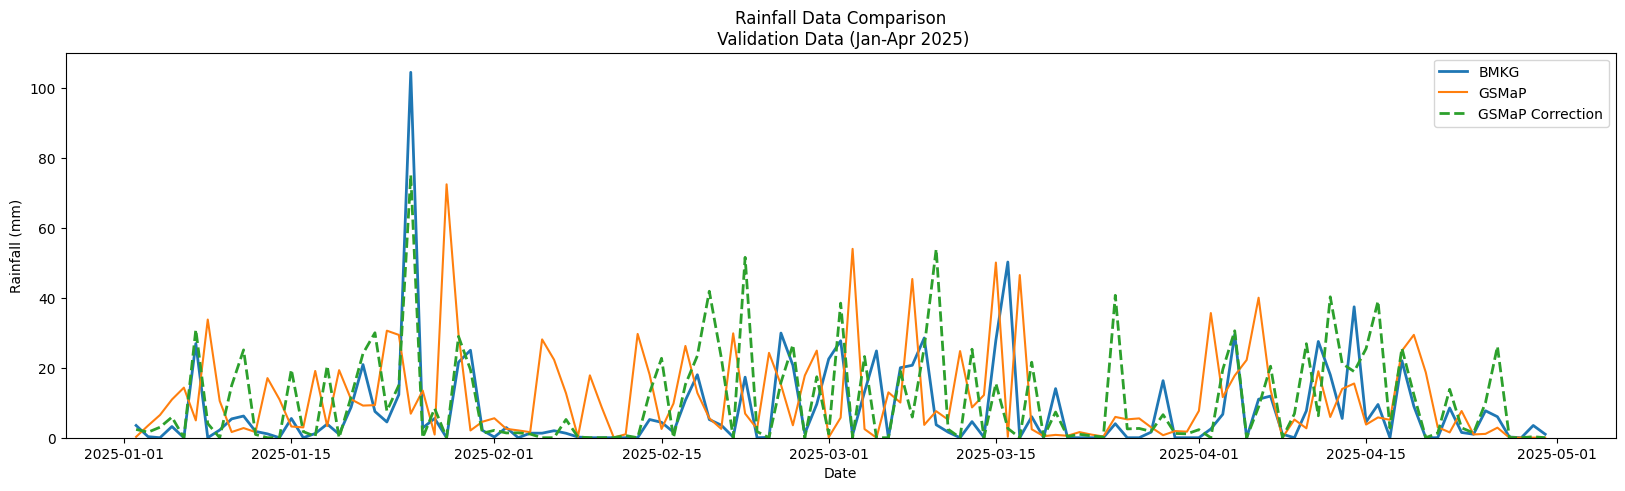

In [654]:
plt.figure(figsize=(20,5))
plt.plot(df_2025['DATE'], df_2025['RR'], label='BMKG',linewidth=2)
plt.plot(df_2025['DATE'], df_2025['GSMaP'], label='GSMaP')
plt.plot(df_2025['DATE'], df_2025['Corrected Rainfall'], label='GSMaP Correction',linewidth=2,linestyle='--')
plt.title('Rainfall Data Comparison\n Validation Data (Jan-Apr 2025)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.ylim(0,110)
plt.legend()
plt.show()

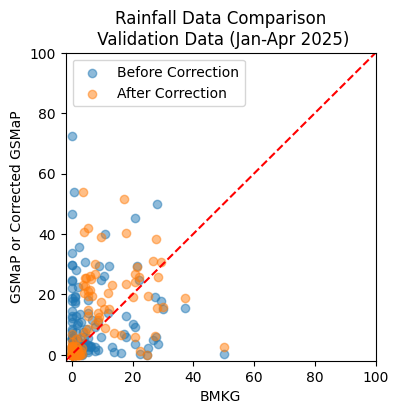

In [651]:
plt.figure(figsize=(4,4))
plt.scatter(df_2025['RR'], df_2025['GSMaP'], label='Before Correction',alpha=0.5,)
plt.scatter(df_2025['RR'], df_2025['Corrected Rainfall'], label='After Correction',alpha=0.5,)
plt.plot([-2, 100], [-2, 100], color='red', linestyle='--')
plt.title('Rainfall Data Comparison\n Validation Data (Jan-Apr 2025)')
plt.xlabel('BMKG')
plt.ylabel('GSMaP or Corrected GSMaP')
plt.xlim(-2,100)
plt.ylim(-2,100)
plt.legend()
plt.show()

<a href="https://www.linkedin.com/in/iqbalfauzanh/"><img src="https://img.shields.io/badge/-© 2025 Iqbal Fauzan Herlambang-417DAC?style=for-the-badge&logoColor=white"/></a>